# <center>  Exporing trip duration and length for Toronro Bike Sharing  </center>

### <center> Date: February 1 </center>
<center>  Luyang Shang </center>


Bike Sharing Toronto is a bicycle sharing system located in Toronto. Recent years, there is a significant increasing on number of people using shared bike in Toronto, while leads to a rapid development of the Toronto bike sharing company. Therefore, I decide to make deep analysis using Bike share Toronto dataset and weather data to understand the factors affecting the ride length for bike sharing customers.

**The data**

The data about bike sharing is collected by system of third party, which provide various information about bike sharing user. From the website, we could observe that the data including the following information.
- Trip start day and time
- Trip end day and time
- Trip duration
- Trip start station
- Trip end station
- User type 


The data are available at https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/. The data is a ZIP file containing multiple CSVs, separating by quarters. I will use the data from 2016 Q3, Q4 and 2017 whole years to perform the data analysis. By reading the term of uses, you should notice that we can use the data for non-commercial purpose and indicating where the the data available at. The data might only be used by me, and We cannot rent, lease the sublices of the data, shall not transfer the data product to others for commercial purpose. 

To see more clearly, I will combine the 6 data and display it. However, by observing data, there are some significant problems related to the dataframe. We need to fix it before combining those 6 data

In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("Bikeshare Ridership (2017 Q1).csv")
df1.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
0,712382,1/1/2017 0:00,1/1/2017 0:03,223,7051,Wellesley St E / Yonge St Green P,7089,Church St / Wood St,Member
1,712383,1/1/2017 0:00,1/1/2017 0:05,279,7143,Kendal Ave / Bernard Ave,7154,Bathurst Subway Station,Member
2,712384,1/1/2017 0:05,1/1/2017 0:29,1394,7113,Parliament St / Aberdeen Ave,7199,College St W / Markham St,Member
3,712385,1/1/2017 0:07,1/1/2017 0:21,826,7077,College Park South,7010,King St W / Spadina Ave,Member
4,712386,1/1/2017 0:08,1/1/2017 0:12,279,7079,McGill St / Church St,7047,University Ave / Gerrard St W,Member


In [3]:
df2016_1 = pd.read_csv("bikeshare-ridership-2016-q3.csv")
df2016_1.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
0,53279,7-9-16 1:03,7-9-16 1:15,714,Dundas St E / Regent Park Blvd,Danforth Ave / Ellerbeck St,Member
1,53394,7-9-16 2:15,7-9-16 2:22,417,Riverdale Park North (Broadview Ave),Dundas St E / Regent Park Blvd,Member
2,58314,7-10-16 17:04,7-10-16 17:36,1904,Dundas St E / Regent Park Blvd,Queen St W / Close Ave,Member
3,60784,7-11-16 1:45,7-11-16 1:58,784,Union Station,Dundas St E / Regent Park Blvd,Member
4,93164,7-18-16 13:35,7-18-16 13:42,443,Front St W / Blue Jays Way,Front St / Yonge St (Hockey Hall of Fame),Member


- The numbers of variables for each dataframe does not match, data for 2017 contain 9 columns, while data for 2016 only contains 7 columns, the difference is the station ID.
- The time format doesn't match.
- Inconsistent time zone for different data

First, I imported the required libraries, then to create a joint dataframe from 6 data, I create a dictionary where the key is the name of each data, the value of dictionary is used to standardize time zone, eliminating the influence of different time zone. Finally, I concatenate the data one by one and modify the format for start_time and end_time.

In [4]:
from datetime import timedelta
from fuzzywuzzy import fuzz
from pandas.api.types import CategoricalDtype

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import datetime as dt
import re
import json
import urllib

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
# the key of the dictionary is the data name, while the value is the number of time we need to shift to keep all 
# data in the same time zone

date_formats = {
    'Bikeshare Ridership (2017 Q1).csv': -4,
    'Bikeshare Ridership (2017 Q2).csv': -4,
    'Bikeshare Ridership (2017 Q3).csv': 0,
    'Bikeshare Ridership (2017 Q4).csv': 0,
    "bikeshare-ridership-2016-q3.csv" : 0,
    "bikeshare-ridership-2016-q4.csv": 0
}
df = pd.DataFrame() # Initiate an empty DataFrame

for data, value in date_formats.items():
    tmp = pd.read_csv(data)
    
    # Read the datetime in the specified format
    tmp['trip_start_time'] = pd.to_datetime(tmp["trip_start_time"])
    # Convert the input time to the Easter timezone
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=value)
    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)

Then, as I mention previously, the data in 2016 does not consist from_station_id and to_station_id. To deal with it, we need additional data to help us match station id with station name. 

The additional data is adapted from https://open.toronto.ca/dataset/bike-share-toronto/. The data contains information of 463 bike sharing station including station_id, name, lat, lon. I will use the data for following two ways

- use the station_id and staion_name to fill the missing value for our original dataframe
- use lat and lon to calculate the distance between each trip.

In [8]:
# load station data
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

bikeshare_stations = pd.DataFrame(json.loads(r.content)['data']['stations'])

# only keep columns name, lat and lon
bikeshare_stations = bikeshare_stations.loc[:, ['name', 'lat', 'lon']]

In [9]:
bikeshare_stations.head()

,name,lat,lon
0,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,Lower Jarvis St / The Esplanade,43.647992,-79.370907
2,St. George St / Bloor St W,43.667333,-79.399429
3,Madison Ave / Bloor St W,43.667158,-79.402761
4,University Ave / Elm St,43.656518,-79.389099


In [10]:
# merge two datafrma 
df = df.merge(bikeshare_stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(bikeshare_stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()

In [11]:
df = df.drop(columns=["to_station_name", "from_station_name"])

**Data analysis**

We want to perform a data analysis on trip length, to determine which factor could contribute to user’s trip length.  To come up solution, I choose to perform data analysis from multiple perspective, Including examining the influence of membership of bike share user and the influence of weather on trip length. 

Before starting to analysis, a common question is what is trip length? How we should define it. I  personally define trip length into following two ways,

- the trip duration for each travel
- the distance travel for each trip

Considering the following histogram, which shows the distribution of trip duration seconds， you might notice the strange behavior of the data, the data experience a wide spread, ranging from 0 to 6380000. It is impossible for people to spend such long time riding bicycle, indicating the existing of outliers. 

In [12]:
df.trip_duration_seconds.describe()

count    1.288606e+06
mean     1.051969e+03
std      1.044271e+04
min      2.000000e+00
25%      4.220000e+02
50%      6.710000e+02
75%      1.045000e+03
max      6.382030e+06
Name: trip_duration_seconds, dtype: float64

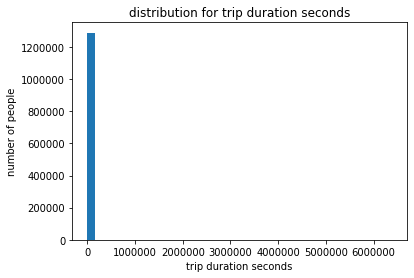

In [13]:
fig = plt.figure()
plt.hist(df.trip_duration_seconds, bins=40)
plt.title("distribution for trip duration seconds")
plt.xlabel("trip duration seconds")
plt.ylabel("number of people")
plt.show()

The method I use to remove outlier is by considering interquartile range (IQR), which is defined for data between first qunatile and third qunatile, The data has value below (first qunatile - 1.5* IQR) and beyond (third quantile + 1.5 * IQR) are considered to be outliers.

In [14]:
# remove the outlier using interquartile range
def remove_outlier(column):
    first = df[column].quantile(0.25)
    third = df[column].quantile(0.75)
    IQR = third - first
    df_out = df.loc[(df.trip_duration_seconds < (third + 1.5 * IQR)) & (df.trip_duration_seconds > (first - 1.5 * IQR))]
    return df_out

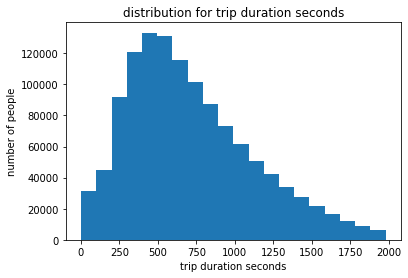

In [15]:
df = remove_outlier("trip_duration_seconds")
fig = plt.figure()
plt.hist(df.trip_duration_seconds, bins = 20)
plt.title("distribution for trip duration seconds")
plt.xlabel("trip duration seconds")
plt.ylabel("number of people")
plt.show()

However, some problems still exist in the data, many of data has trip_duration_seconds less than 60 seconds. By further digging into the data, I realize the from_staion_name and to_station_name are same for data with trip_duration_seconds less than 60, the primary reason might be the users mistake starting a new trip, and they return the bike immediately. To ensure accuracy, I decide to remove those data.

In [16]:
df[df.trip_duration_seconds < 60].head(10)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,to_station_id,user_type,name_from,lat_from,lon_from,name_to,lat_to,lon_to
2174,1948068,2017-09-27 17:44:00,9/27/2017 17:44,2,NaN,NaN,Member,80 Clinton St (North of College),43.656296,-79.414663,Bathurst Subway Station,43.666667,-79.411667
2584,1949480,2017-09-27 19:24:00,9/27/2017 19:24,2,NaN,NaN,Member,Ossington Ave / Harrison St,43.651111,-79.421389,Bathurst Subway Station,43.666667,-79.411667
2671,1258556,2017-07-01 21:01:00,7/1/2017 21:01,24,NaN,NaN,Casual,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2675,1281275,2017-07-05 08:45:00,7/5/2017 8:45,26,NaN,NaN,Member,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2677,1289894,2017-07-05 21:45:00,7/5/2017 21:45,24,NaN,NaN,Member,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2679,1360153,2017-07-15 16:38:00,7/15/2017 16:39,29,NaN,NaN,Casual,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2680,1368252,2017-07-16 19:41:00,7/16/2017 19:41,28,NaN,NaN,Casual,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2681,1373938,2017-07-17 17:51:00,7/17/2017 17:52,29,NaN,NaN,Member,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2682,1374281,2017-07-17 18:21:00,7/17/2017 18:21,26,NaN,NaN,Casual,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667
2683,1377282,2017-07-18 08:40:00,7/18/2017 8:40,26,NaN,NaN,Casual,Bathurst Subway Station,43.666667,-79.411667,Bathurst Subway Station,43.666667,-79.411667


In [17]:
# we only keep the data with trip_duration seconds greater than 60
df = df[df.trip_duration_seconds > 60]

From this bar plot, we can see the IQR for users is between 400 and 950, indicating most of user are using the bicycle for short and middle distance travel

<Figure size 432x288 with 0 Axes>

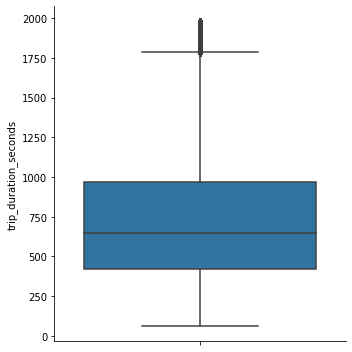

In [18]:
fig = plt.figure()
sns.catplot(y="trip_duration_seconds", kind="box", data=df)
plt.show()

After dealing with trip duration,  it is time to create trip distance by using lat and lon for from_station and to_station. 

In [19]:
from geopy import distance

In [20]:
# store the value into a list
temp = []
for index, row in df.iterrows():
    temp.append(distance.distance((row['lat_from'], row['lon_from']), (row['lat_to'], row['lon_to'])).km * 1000)

In [21]:
# create new column called distance
df["distance"] = np.array(temp)

In [22]:
# after calculating distance we drop lot and lat
df = df.drop(columns=["lat_from", "lon_from", "lat_to", "lon_to"])

From the graph, we could see the histogram is unimodal and right-skewed, spreading from 0 to 10000 with most of the people centered at 2000 meters, indicating most people taking bicycle for short or middle length travel. Notice that some trips have zero travel distance, it might be caused by following two reason.

- The data set contains incorrect information
- The from_staion is same as to_station

I personally prefer the second explanation since we expect some riders may return to from_station after finishing riding. Therefore I decide to keep those data.

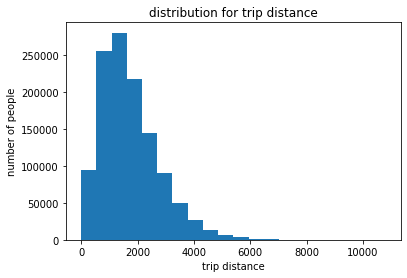

In [23]:
df = remove_outlier("distance")
fig = plt.figure()
plt.hist(df.distance, bins = 20)
plt.title("distribution for trip distance")
plt.xlabel("trip distance")
plt.ylabel("number of people")
plt.show()

For future data analysis, I decide to record the current time for each travel

In [24]:
# Create the day of week Category by iterrating over 7 days (March 4th, 2019 is a Monday)
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create the month Category by iterrating over the months
months = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

In [28]:
# Create the day of week Category by iterrating over 7 days (March 4th, 2019 is a Monday)
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)

# Create the month Category by iterrating over the months
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)

In [25]:
df['trip_start_time'] = pd.to_datetime(df['trip_start_time'])

In [29]:
# get corresponding time
df['Date'] = df['trip_start_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Quarter'] = df['trip_start_time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Month'] = df['trip_start_time'].apply(lambda x: x.strftime('%B')).astype(month_type)
df['Day of Week'] = df['trip_start_time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df['Hour'] = df['trip_start_time'].apply(lambda x: x.strftime('%H'))
df['YEAR'] = df['trip_start_time'].apply(lambda x: x.strftime('%Y'))

**Is there a relationship between the two variables used for describing trip length ?**

Previously, I give trip length two definition, one is trip duration time and the other is the distance for one trip. 
We make sure those two variables could have a good representation of trip length, I choose to perform a data analysis to examine the relationship between the variables.


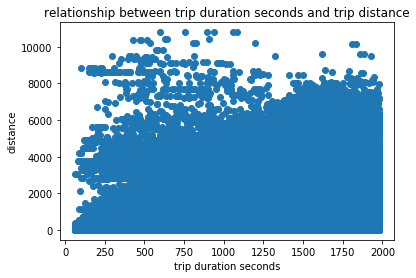

In [30]:
fig = plt.figure()
plt.scatter(df.trip_duration_seconds, df.distance)
plt.title("relationship between trip duration seconds and trip distance")
plt.xlabel("trip duration seconds")
plt.ylabel("distance")
plt.show()

From the graph, we could see there is no relationship between trip duration seconds and distance. It is surprising since the more time people spend, the longer distance people should travel. However, Due to our distance calculating algorithm, if the users return their bicycle to from_station, it will cause zero distance, we decide to temporarily remove those users having zero distance and plot again.

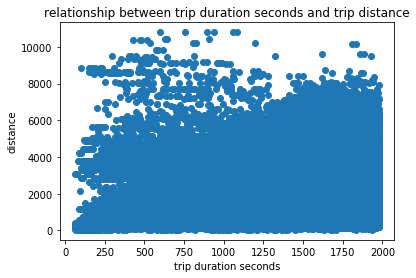

In [31]:
fig = plt.figure()
plt.scatter(df[df.distance > 0].trip_duration_seconds, df[df.distance > 0].distance)
plt.title("relationship between trip duration seconds and trip distance")
plt.xlabel("trip duration seconds")
plt.ylabel("distance")
plt.show()

In [32]:
cov_array = np.cov(df[df.distance > 0].trip_duration_seconds, df[df.distance > 0].distance)

# calculate the covariance between trip_duration_seconds and distance 
covariance = cov_array[0][1]

# correlation = covariance/(std(X) * std(Y))
correlation = covariance /( math.sqrt(cov_array[0][0]) * math.sqrt(cov_array[1][1]))

print(correlation)

0.719906526396344


We could see from graph, there is no relationship between trip_duration_seconds and trip distance. However, I calculate correlation between two variables, the correlation is 0.6 indicating there is a week linear relationship between trip_duration_seconds and trip distance. 

To future investigate trip duration and trip distance, I come to look up distribution of those two variable for different users type.


**Do casual users take shorter trips compared to members?**

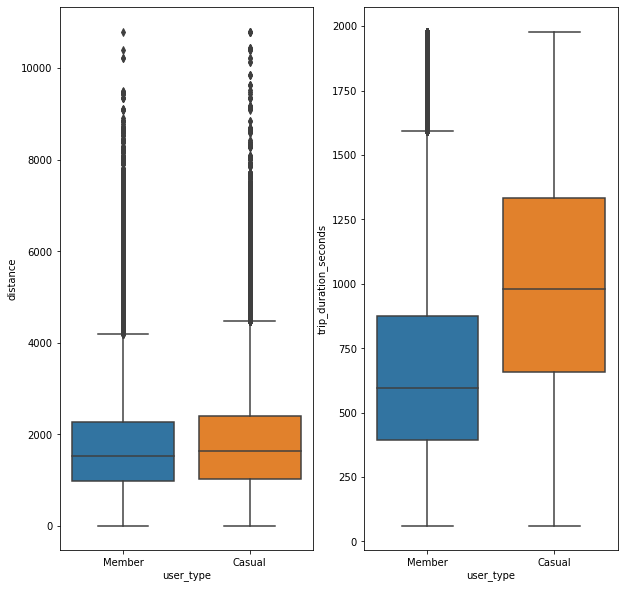

In [33]:
fig, ax1= plt.subplots(1, 2, figsize=(10, 10))
sns.boxplot(y="distance", x='user_type', data=df, ax=ax1[0])
sns.boxplot(y="trip_duration_seconds", x='user_type', data=df, ax=ax1[1])
plt.show()

The boxplot show the distribution of distance and trip_duration_seconds for different type of users. Member and casual user tends to ride within the same distance. While casual users tends to spend longer time riding the bicycle for each travel compared with member. the average time spending for member users is around 700, while for casual user, it is around 1000.

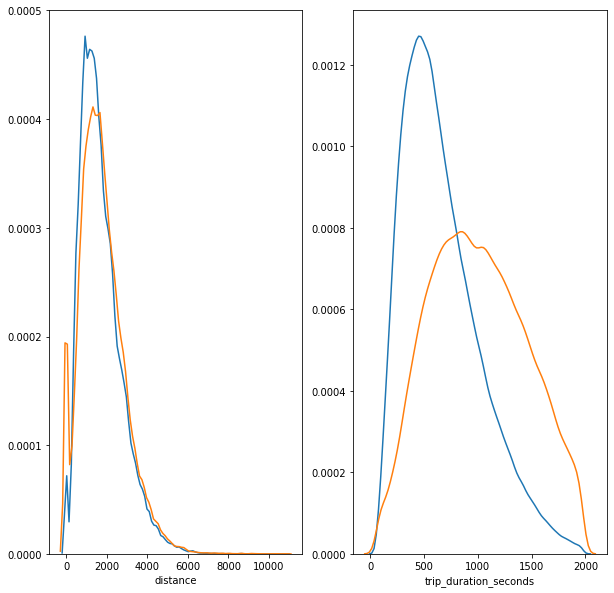

In [34]:
fig, ax= plt.subplots(1, 2, figsize=(10, 10))
for user in ["Member", "Casual"]:
    sns.distplot(df[df['user_type']==user]["distance"], hist=False, ax=ax[0])
    sns.distplot(df[df['user_type']==user]["trip_duration_seconds"], hist=False, ax=ax[1])
plt.show()

Text(0.5, 1.0, 'The number of trip ')

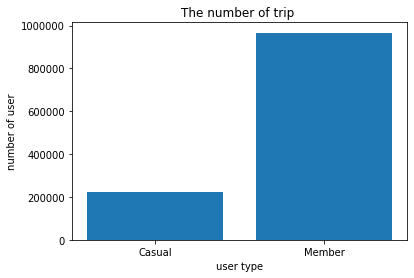

In [35]:
value = df.groupby(df.user_type).count().trip_id
plt.bar(list(value.keys()), value)
plt.xlabel("user type")
plt.ylabel("number of user")
plt.title("The number of trip ")

The histogram shows the same result as boxplot, both type of users travel the similar distance, while casual users tend to spend longer time traveling compared with member. However, the number of member user is much more higher than casual users.

 The result is surprising at first look. However, it becomes reasonable after I go to toronto bike share website to check their price. I copy the price policy from website and display it 

- Member: Join as an Annual Member for only 99 dollar per year. Enjoy unlimited 30 minute rides year round for as little as 30¢ a day!

- Casual: Purchase a Single Trip for 3.25 dollar for a one-way trip up to 30-minutes in length.

The main difference is that, member does not have restriction on the number of ride they can take, while for casual users, once they return their bicycle, they can no longer re-take it unless they pay additional money. 

To further investigate the difference of trip length for casual and member users, I plot the distribution of trip length over the week for different types of users.

If we look at the distribution of trip duration seconds across week, we could see causal users tend to take longer ride compared with member, however, the distribution of duration seconds for member looks more stable, while for casual users, they spend less time on riding on weekdays. On the other hand, there is no significant difference of distance among different groups of users.

<Figure size 432x288 with 0 Axes>

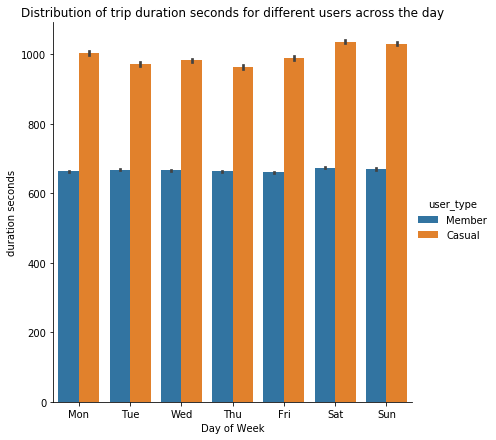

In [38]:
fig = plt.figure()
sns.catplot(x="Day of Week", y="trip_duration_seconds", hue="user_type", data=df,
                height=6, kind="bar")
plt.title("Distribution of trip duration seconds for different users across the day")
plt.ylabel("duration seconds")
plt.show()

<Figure size 432x288 with 0 Axes>

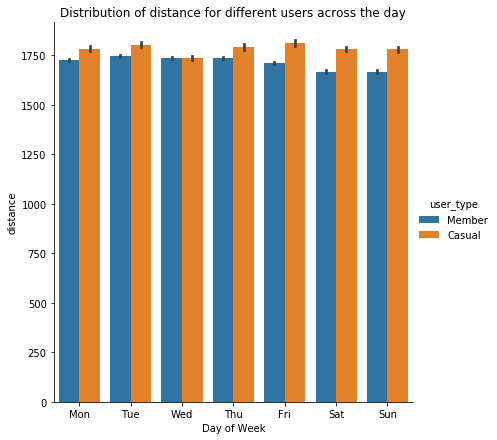

In [39]:
fig = plt.figure()
sns.catplot(x="Day of Week", y="distance", hue="user_type", data=df,
                height=6, kind="bar")
plt.title("Distribution of distance for different users across the day")
plt.ylabel("distance")
plt.show()

Notice, one strange thing is that there is a significant decrease of trip duration and trip distance for causal user on Wednesday, I decide to look at the distribution of number of casual users taking the bicycle over the week.

In [40]:
df_casual = df[df["user_type"] == "Casual"]
df_member = df[df["user_type"] == "Member"]

In [41]:
weekday_casual = df_casual["Day of Week"].groupby(df_casual["Day of Week"]).count()
weekday_member =  df_member["Day of Week"].groupby(df_member["Day of Week"]).count()

In [42]:
week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

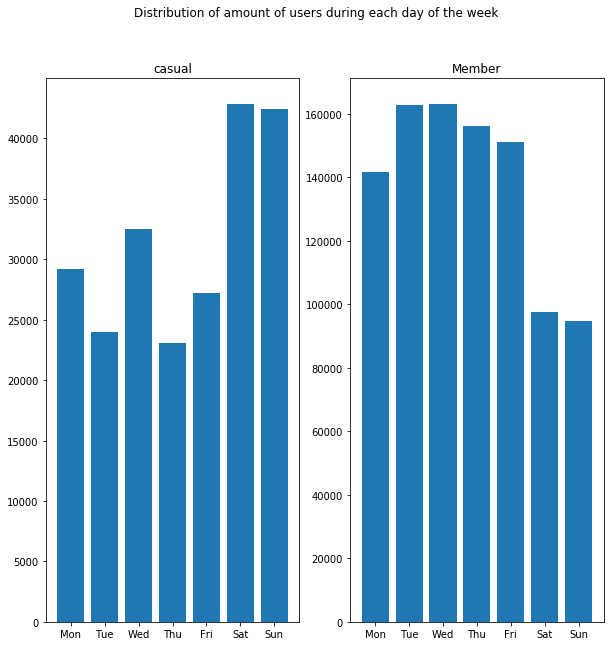

In [43]:
fig, ax= plt.subplots(1, 2, figsize=(10, 10))
ax[0].bar(week, weekday_casual)
ax[0].set_title("casual")
ax[1].bar(week, weekday_member)
ax[1].set_title("Member")
fig.suptitle('Distribution of amount of users during each day of the week')
plt.show()

The graph shows that the distribution of ridership among week period, member users tends to use their bike on weekdays, while casual users tends to use the bike on weekends, indicating most member users use the bicycle for transportation to working space. While, for member, they tends to use the bike for enjoyment. The graph also shows the increase of ridership for causal user on wed.

In conclusion, we found the number of member users is much more higher than casual users. For trip length, the distribution of distance for both types of users is similar, indicating both users take bicycle for short distance travel. For trip duration, casual users tend to spend more time on each trip. company's payment mechanism might be potential factor to this phenomenon。

To get more information about trip length, I decide to investigate the relationship between weather and trip length

**Does season or weather affect trip length?**

To answer this question, we use the data provided by Government of Canada website. The data contains information temperature and weather for each days. 
Firstly, I extracted the data by scraping the weather info from the government provided website. Then, I add the variable time in the data set preparing for later merge.

In [44]:
days = []
for i in range(1, 32):
    days.append(str(i))

In [45]:
#scrap the weather info from the website above
months = df.Month.unique()

weather = pd.DataFrame()
for i in range(6, 13):
    
    temp =  pd.read_html("https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2016&Month={}".format(i), header = 0)[0]
    temp = temp[0:-4]
    temp["year"] = "2016"
    temp["month"] = months[i - 1]
    # we want to time format like 2016-03-03
    if i < 10:
        temp["time"] = "2016-0" + str(i) + "-" + temp['DAY']
    else:
        temp["time"] = "2016-" + str(i) + "-" + temp['DAY']
            
    weather = pd.concat([weather, temp], sort=False).reset_index(drop=True)
    

In [46]:
#get dataframe of weather info in 2017

for i in range(1, 13):
    #read from the website
    temp =  pd.read_html("https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month={}".format(i), header = 0)[0]
    temp = temp[0:-4]
    temp["year"] = "2017"
    temp["month"] = months[i - 1]
    if i < 10:
        temp["time"] = "2017-0" + str(i) + "-" + temp['DAY']
    else:
         temp["time"] = "2017-" + str(i) + "-" + temp['DAY']
    weather = pd.concat([weather, temp], sort=False).reset_index(drop=True)

In [47]:
# convert the following colunm into float
weather = weather[~weather["Mean Temp Definition°C"].str.contains("Legend")]
weather = weather[~weather["Total Rain Definitionmm"].str.contains("Legend")] 
weather = weather[~weather["Total Snow Definitioncm"].str.contains("Legend")] 
weather = weather.astype({"Mean Temp Definition°C": float, "Total Rain Definitionmm": float, "Total Snow Definitioncm": float})

In [48]:
df = df.merge(weather, how='inner', left_on='Date', right_on='time')

To investigate the influence of weather to ridership, I will examine the distribution of ridership across months for 2017 data.

In [49]:
# groupby Month and user_type
df_month = df.groupby(['Month', 'user_type', "year"], as_index=False).count()[['Month', 'user_type', 'time', "year"]].rename(columns={"time": "count"})

<Figure size 432x288 with 0 Axes>

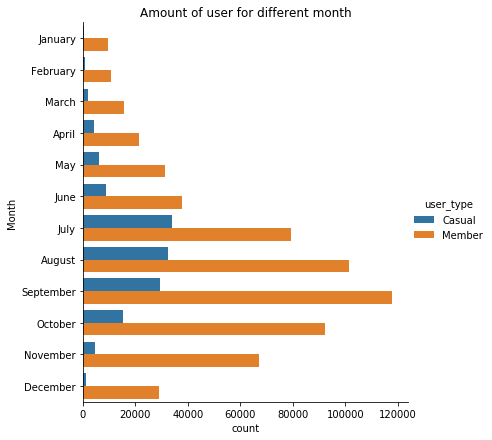

In [51]:
fig = plt.figure()
sns.catplot(y="Month", x="count", hue="user_type", data=df_month[df_month.year=='2017'], height=6, kind="bar", 
            order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.title("Amount of user for different month")
plt.ylabel("Month")
plt.show()

The data show distinct users behaviour among each month, Indicating least people take bike on January and February. Starting with June, the number of users increase dramatically, and reach peak at September and start to decrease, suggesting people tend to take bike on the summer and avoid riding in the winter.

Although we cannot state the primary factor contributing to ridership demand is weather, the finding indicates existing relationship between Weather and number of users. There are two potential factors could leads to this situation.

- temperature
- raining (snowing)

To verify my assumption, I will make analysis on both temperature and raining(snowing)

To prepare for analysis, I firstly create a column called temperature, which states the information for temperature . To dig into the user behaviour among different temperature, I round down temperature to make sure we can count the number of trip on individual temperature.

In [52]:
df["temperature"] = round(df["Mean Temp Definition°C"], 0)

In [53]:
# The function is used to create folloing dataframe. 
def f(row):
    temp = {}
    temp["temperature"] = row["temperature"].mean()
    temp["amount"] = row["trip_id"].count()
    temp["distance"] = row["distance"].count()
    temp["duration"] = row["trip_duration_seconds"].mean()
    return pd.Series(temp)

ridership = df.groupby(["temperature"], as_index=False).apply(f)

In [54]:
ridership.head()

,temperature,amount,distance,duration
0,-19.0,283.0,283.0,527.148410
1,-18.0,491.0,491.0,632.236253
2,-16.0,488.0,488.0,657.157787
3,-14.0,195.0,195.0,646.789744
4,-13.0,329.0,329.0,585.595745


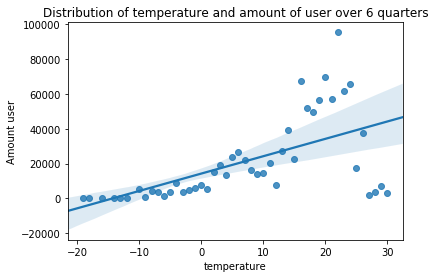

In [55]:
fig = plt.figure()
sns.regplot(x=ridership["temperature"], y=ridership["amount"])
plt.ylabel("Amount user")
plt.title("Distribution of temperature and amount of user over 6 quarters")
plt.show()

The scatter plot display the relationship between number of users and temperature, we could observe a moderate, linear, positive relationship, indicating the increase of temperature results in increasing number of user. More precisely, temperature and number of users follow a linear relationship when temperature is less than 15, and become more unrelated when temperature continues to increase. 

To look deeper, I plot the other scatter plot to show the relationship between two variables when temperature is less than 15 and calculate the correlation for those two cases. 

Both graph and correlation confirm my observation.

In [56]:
def get_correlation(i):
    cov_array = np.cov(ridership[ridership.temperature <= i]["temperature"], ridership[ridership.temperature <= i]["amount"])

    # calculate the covariance  between trip_duration_seconds and distance 
    covariance = cov_array[0][1]

    correlation = covariance /(math.sqrt(cov_array[0][0]) * math.sqrt(cov_array[1][1]))
    return correlation

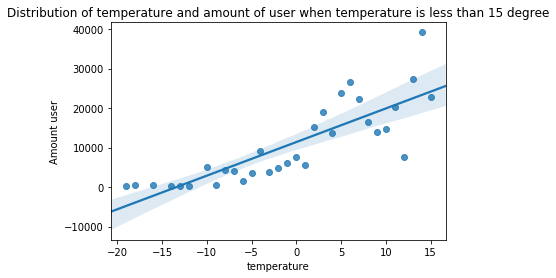

In [57]:
fig = plt.figure()
sns.regplot(x=ridership[ridership.temperature <= 15]["temperature"], y=ridership[ridership.temperature <= 15]["amount"])
plt.ylabel("Amount user")
plt.title("Distribution of temperature and amount of user when temperature is less than 15 degree")
plt.show()

The correlation for temperature less than 15 is around 0.832, which is much higher than the correlation for entire population. Both graph and correlation indicates bicycle user is sensitive to low temperature, so we could predicate increasing temperature results in increasing number of users when temperature is relatively low.

In [58]:
# the correlation of maximum temperature
print("correlation for entire population: " + str(round(get_correlation(max(ridership.temperature)), 3)))
# The correlation between temperature and amount user for for temperature less than 20 degree
print("correlation when temperature less than 15 :" + str(round(get_correlation(15), 3)))

correlation for entire population: 0.59
correlation when temperature less than 15 :0.832


One interesting think to consider is which groups of people are more sensitive to temperature. The following graph suggests member are more sensitive to temperature compared with causal users

In [59]:
# use for plot
compare_temperature = df.groupby(["user_type", "temperature"], as_index=False).count()[["temperature","user_type", "trip_id"]]

<Figure size 432x288 with 0 Axes>

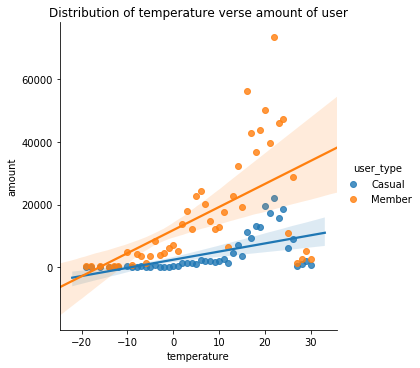

In [60]:
fig = plt.figure()
sns.lmplot(x="temperature", y="trip_id", hue="user_type", data=compare_temperature)
plt.title("Distribution of temperature verse amount of user")
plt.ylabel("amount")
plt.show()

Now, we already find out there is a linear relationship between number of user and temperature, let's look at the influence of temperature on trip length.

The following graph provide same implication with previously graph, indicating the increase of temperature results in increase of duration and distance. For distribution of temperature verse distance, the shape of the graph is similar to previous one. We get the same observation that the correlation decreases as the temperature increase when temperature is greater than 15. On the other hand, the distribution of riding duration follows a linear relationship all the time.

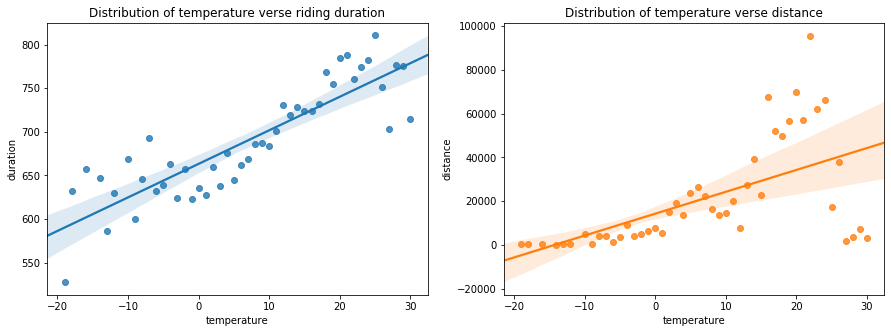

In [61]:
fig, ax= plt.subplots(1, 2, figsize=(15, 5))
sns.regplot(x=ridership["temperature"], y=ridership["duration"], ax=ax[0])
sns.regplot(x=ridership["temperature"], y=ridership["distance"], ax=ax[1])
ax[0].set_title("Distribution of temperature verse riding duration")
ax[1].set_title("Distribution of temperature verse distance")
plt.show()

After finding the implication of temperature, I come to analyse the other potential factor: raining or snowing. To make analysis easier, I make following data frame

In [62]:
# the column we want to keep
columns = ["Month", "DAY", "Total Rain Definitionmm", "Total Snow Definitioncm", "distance", "trip_duration_seconds"]

# get the datafrme shows the mean of .... for each day in each month
rain_snow = df.groupby(["Month", "DAY"], as_index=False).mean()[columns].rename(columns = {"trip_duration_seconds": "duration", "Total Rain Definitionmm": "rain", "Total Snow Definitioncm" : "snow"})

In [63]:
pd.set_option("precision", 3)
rain_snow.head()

,Month,DAY,rain,snow,distance,duration
0,January,01,0.0,0.0,1570.578,686.199
1,January,02,NaN,NaN,NaN,NaN
2,January,03,15.8,0.0,1619.075,625.228
3,January,04,NaN,NaN,NaN,NaN
4,January,05,NaN,NaN,NaN,NaN


Then, I display the plot to show the relationship between Total rain Definitioncm and trip length. Surprisingly, the graph shows there is no relationship between Total rain Definitioncm and trip length. 

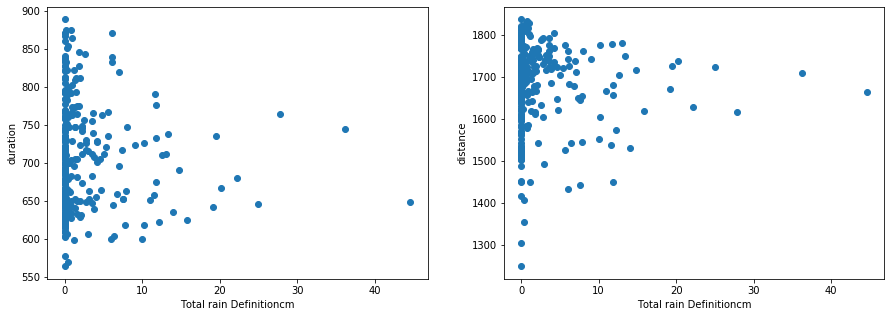

In [64]:
fig, ax= plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(x=rain_snow.rain, y=rain_snow.duration)
ax[1].scatter(x=rain_snow.rain, y=rain_snow.distance)
ax[0].set_xlabel("Total rain Definitioncm")
ax[1].set_xlabel("Total rain Definitioncm")
ax[1].set_ylabel("distance")
ax[0].set_ylabel("duration")
plt.show()

Since not every month has snow, to analyse the influence of snow for ridership, I firstly display the distirbution of the snow

The graph indicates only December, February experience relative large snow Definitioncm, to explore the influence of snow for trip length, we only consider December, which has the largest snow Definitioncm.

The graph provide similar observation that no evidence could show there is a relationship between snow Definitioncm and trip length.

<Figure size 432x288 with 0 Axes>

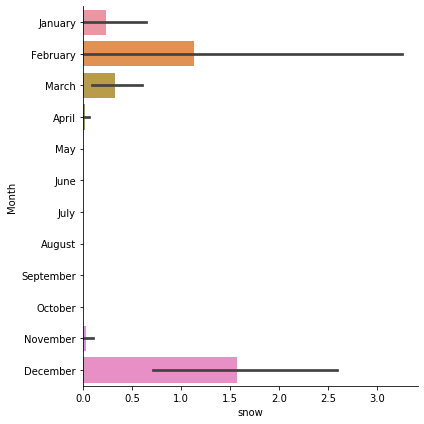

In [65]:
fig = plt.figure()
sns.catplot(y="Month", x="snow", data=rain_snow, height=6, kind="bar")
plt.show()

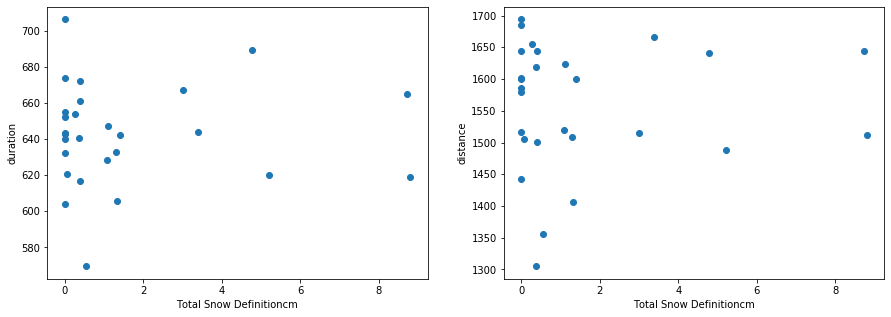

In [66]:
fig, ax= plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(x=rain_snow[rain_snow.Month=='December'].snow, y=rain_snow[rain_snow.Month=='December'].duration)
ax[1].scatter(x=rain_snow[rain_snow.Month=='December'].snow, y=rain_snow[rain_snow.Month=='December'].distance)
ax[0].set_xlabel("Total Snow Definitioncm")
ax[1].set_xlabel("Total Snow Definitioncm")
ax[1].set_ylabel("distance")
ax[0].set_ylabel("duration")
plt.show()

**Conclusion**

This data analysis aim to find the factors contribute to duration seconds and trip distance which are identified as trip length. Most users spend 400s and 950s riding, indicating most of user are using the bicycle for short and middle distance travel, while casual tends to take a longer time on each trip due to the payment mechanism of bike sharing. The distribution of distance confirm the fact most of user are using the bicycle for short and middle distance trave.
Then I further explore the distribution of trip length over a week, we observes member users tends to use their bike on weekdays, while casual users tends to use the bike on weekends, The finding has important implication that most member users use the bicycle for transportation to working space. While, for member, they tends to use the bike for enjoyment. The graph also shows the increase of ridership for causal user on wed.
For relationship between duration seconds and trip distance, the scatter plot and correlation show there is a week relationship between those two variables, indicating riding longer does not imply a longer riding distance.
All bicycle users are sensitive to temperature, especially to low temperature. The distribution of ridership for each month describes the average bicycle counts during Winter and Spring differs from that of Summer and Fall. Most users use sharing bicycle on the summer. Meanwhile the linear model implies there is a positive relationship between number of users and temperature, member is more sensitive to temperature since we observe a larger increasing number of users for unit increasing of temperature. Although we cannot confirm temperature is a leading factor for increasing number of users, all evidence shows there is a relationship between number of users and temperature.
surpingly, there is no relationship between number of users and the raining or snowing Definitioncm. There might be caused by following two reasons:
-	Rain or snow lasted only a short period, so users might still use sharing bicycle after raining, snowing finish
-	Raining or snowing influence the ridership in a few days, making our observation inconsistent.

